# Lab3. Pytorch Classification (Logistic Regression vs MLP)  

이 실습에서는 Classification Problem을 `pytorch`로 해결해볼 겁니다! 두가지 모델(Linear Regression, MLP)을 둘 다 구현해보고 모델이 생각하는 데이터 분포를 시각화해서 MLP가 실제로 non-linear Decision-Boundary를 가질 수 있는지 살펴보는게 본 실습의 묘미입니다.


**이 문서를 구글 Colab에서 쉽게 실행해보는법**  
1. [제가 미리 만들어놓은 이 링크](https://colab.research.google.com/github/heartcored98/Standalone-DeepLearning/blob/master/Lec2/Lab3_pytorch_classification_demo.ipynb)를 눌러 본 .ipynb 파일을 구글 Colab에서 바로 열 수 있습니다. 이때 구글에 로그인을 해야 합니다.
2. 아무 셀이나 선택한 후 `Ctrl+Enter`를 눌러 실행해보면 **[경고: 이 노트는 Google에서 작성하지 않았습니다]**라고 뜨는데 `실행 전에 모든 런타임 재설정`을 선택한 채로 `무시하고 계속하기`를 눌러줍니다.  
3. **[모든 런타임 재설정]** 이 뜰 텐데 `예`를 눌러줍니다.  
4. 잠시 구글 서버의 배치가 되면서 우상단에 `연결중` -> `초기화중` -> `연결됨`이 뜨면서 실행이 가능한 상태가 됩니다.  

**구글 Colab에서 실습후 저장하는법**  
**쉽게 실행보는법**을 따라오셨다면 Colab에서 임시 노트북으로 열리기 때문에 `파일`->`드라이브로 저장`을 눌러서 여러분의 구글 드라이브에 저장하거나 `파일` -> `.ipynb 다운로드`를 눌러서 다운로드 해줍시다.   

*Written by. 조재영(whwodud9@kaist.ac.kr) 2019.01.20 *

### Install Pytorch 1.0 (For Google Colab)

In [1]:
"""#구글 Colab에서 실행할 때는 이 주석을 해제하시고 실행해서 pytorch 1.0을 깔아주세요!
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)
"""

'#구글 Colab에서 실행할 때는 이 주석을 해제하시고 실행해서 pytorch 1.0을 깔아주세요!\n!pip install -q torch==1.0.0 torchvision\nimport torch\nprint(torch.__version__)\n'

### 1. Data Generation  (Preparation)

Classification 실습에 사용할 데이터를 만들어봅시다. 이번에도 X가 2차원 Y가 1차원인 상황입니다. X는 모두 continuous space에 존재하고 Y는 class이기 때문에 discrete space에 분포합니다. 이번에는 방사형 데이터 분포를 가상으로 만든 후에 두 모델들이 비선형 decision-boundary를 형성할 수 있는지 테스트해보죠.

**Data Set**  
$$X_{train} \in \mathcal{R}^{8000 \times 2}, Y_{train} \in \mathcal{Z}^{8000}$$  
$$X_{val} \in \mathcal{R}^{1000 \times 2}, Y_{val} \in \mathcal{Z}^{1000}$$  
$$X_{test} \in \mathcal{R}^{1000 \times 2}, Y_{test} \in \mathcal{Z}^{1000}$$

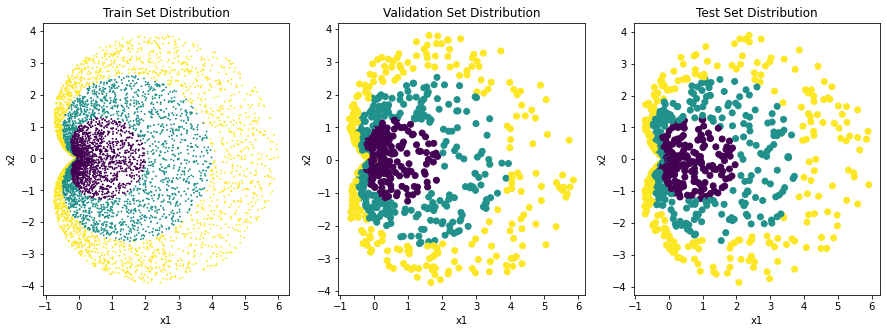

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
#input은 2차원. output은 3차원인 데이터셋이다. 

# ====== Generating Dataset ====== #
r = np.random.rand(10000)*3 #r은 10000개
theta = np.random.rand(10000)*2*np.pi #세타도 10000개
y = r.astype(int) #int로 바꾸면 소숫점 부분이 다 날아가서 정수형으로 바꿈
r = r * (np.cos(theta) + 1) 
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T 

# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')


ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')

plt.show()

### 2. Hypothesis Define (Model Define)  

Logistic Regression Model을 파이토치로 구현할 때는 Regression 문제를 풀 때와 똑같이 `nn.Linear` 모듈과 non-linear activation fuction만 달아주면 됩니다. **Model 내에서 Softmax를 사용할 필요가 없습니다..!** 그 이유는 softmax 함수가 뒤에 나오는 파이썬 내장 **CrossEntropyLoss 함수에 들어가** 있기 때문이죠.


**Multi-Label Logistic Model**   
$$z = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 3}, b \in \mathcal{R}^{3}, z \in \mathcal{R}^{N \times 3}$$  
$$H = \ softmax(z) \ \ (  H \in \mathcal{R}^{N \times 3})$$  


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200}$$  

$$z = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 3}, b_2 \in \mathcal{R}^{3}, z \in \mathcal{R}^{N  \times 3})$$  

$$H = \ softmax(z) \ \ ( H \in \mathcal{R}^{N \times 3})$$  


In [3]:
import torch
import torch.nn as nn


class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True) #2차원에서 3차원으로
    
    def forward(self, x):
        x = self.linear(x)
        #x= self.softmax(x) 이걸 왜 취하면 안되냐?
        return x
# CrossEntropy costfunction 안에 이미 softmax가 들어가 있다.
# 그래서 softmax를 또 거치면 두번 통과하는 거기 때문에
# nllloss로 바꾸던가 아니면 softmax를 쓰면 안된다. 
    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

### 3. Cost Function Define (Loss Function Define)  

Multi-Label Problem 에서의 Loss Function을 작성해봅시다.  
파이토치의 `nn` 아래에는 다양한 Loss Function이 이미 구현되어 있습니다.  
[여기](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html)에서 파이토치 내부에 구현되어 있는 MSE, Cross-Entropy, KL-Divergence 등을 확인할 수 있습니다.  
이 실습에서는 Classification Problem 이므로 `CrossEntropyLoss()`를 사용해봅시다.  

`input`은 $ N \times Num Class $ 차원을 가지면 되며 float 형태여야 하고,  
`target`은 $ N $ 차원을 가지고 각 엘리먼트는 $ i $ 번째 클래스를 나타내는 int형이면 되는군요.

CrossEntropy Documentation : https://pytorch.org/docs/stable/nn.html#crossentropyloss

In [4]:
cls_loss = nn.CrossEntropyLoss()

# Cross Entropy를 테스트해봅시다
test_pred_y = torch.Tensor([[2,0.1],[0,1]]) #임의로 만들어둠 합이 1이 아니어도 작동한다
test_true_y1 = torch.Tensor([1,0]).long() #long: 정수형 타입. float형을 정수로 바꿔야 오류가 안난다.
test_true_y2 = torch.Tensor([0,1]).long()

print(cls_loss(test_pred_y, test_true_y1)) #True y는 정수형으로 몇 번쨰 클래스인지 알려준다.
print(cls_loss(test_pred_y, test_true_y2))


tensor(1.6763)
tensor(0.2263)


### 4. Train & Evaluation
이제 모델도 정의했고 Loss Function도 정의했으니 한번 학습시켜볼까요?  
저번에는 저희가 직접 파라미터(w 하나)에 따른 loss의 편미분을 유도하고 거기서 나온 그라디언트로 w를 업데이트했는데요.  
`pytorch`에서는 loss.backward() 라는 기능을 쓰면 알아서 loss를 계산되는데 사용한 각 파라미터에 대한 loss의 편미분을 계산해줍니다.  
이후 `optimizer.step()` 함수를 사용하면 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트 해줍니다. 

이 때 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교하게 됩니다. 
그리고 저희가 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산합니다.  
이번에는 Classification Task에서 기본적으로 사용하는 **Accuracy**를 **Metric**으로 활용해보겠습니다.  
accuracy를 계산하는 함수가 이미 `sklearn.metrics`에 구현되어 있으니 불러와 사용하도록 합시다.  

accuracy_score Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  
  
$$ Accuracy = \frac{Number \ of \ correct \ prediction}{Total \ number \ of \ predictions \ made} $$

In [5]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
# model = LinearModel()
# print(model.linear.weight)
# print(model.linear.bias)

model = MLPModel() # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.
#모델 안에 학습 가능한 총 파라미터 수를 세줌

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []


epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
for i in range(epoch): 
    
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y).long() #cross entropy에 넣기 위해 정수로
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    
    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y).long()
    pred_y = model(input_x)   
    loss = cls_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate Accuracy ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        acc = accuracy_score(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_acc.append(acc)
        list_acc_epoch.append(i)

        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_title('True test y')
        
        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.scatter(test_X[:, 0], test_X[:, 1], c=pred_y)
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_title('Predicted test y')
        
        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.scatter(train_X[:, 0], train_X[:, 1], c=pred_y)
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_title('Prediction on train set')

        plt.show()
        print('Epoch: ', i,  'Accuracy: ', acc*100, '%')

# Decision Boundary가 직선이다. 
# 그래서 완벽하게 분류할 수 없다. 

Output hidden; open in https://colab.research.google.com to view.

### 5. Report Experiment  
학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다. 
그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

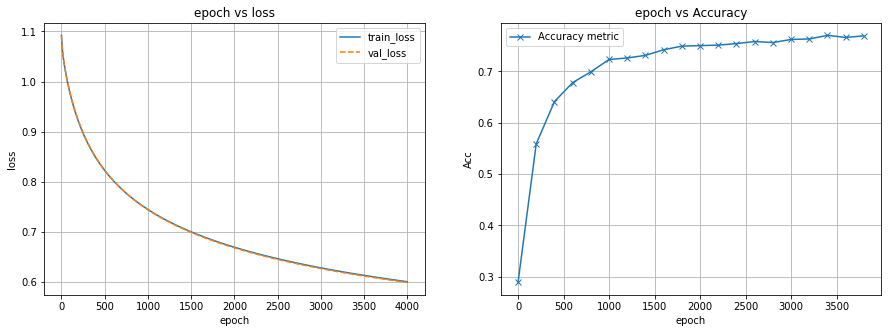

In [6]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()